In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## Estudio de la calidad del aire (AQI)
## Paso 1: importado  de datos csv

In [108]:
#Inspección inicial del DataFrame
datos_calidad_aire = pd.read_csv("globalAirQuality.csv")
print('Forma del Dataframe: ',datos_calidad_aire.shape)
print('Tamaño del Dataframe: ',datos_calidad_aire.size)

Forma del Dataframe:  (18000, 15)
Tamaño del Dataframe:  270000


In [109]:
#ESCRIBIR CABECERA (5 ROWS)
datos_calidad_aire.head()

,timestamp,country,city,latitude,longitude,pm25,pm10,no2,so2,o3,co,aqi,temperature,humidity,wind_speed
0,2025-11-04 18:25:17.554219,US,New York,40.713,-74.006,50.295,108.938,27.998,6.539,52.568,1.096,108,18.504,70.168,3.725
1,2025-11-04 19:25:17.554219,US,New York,40.713,-74.006,32.083,63.043,36.120,4.021,43.536,1.075,90,5.838,80.088,8.969
2,2025-11-04 20:25:17.554219,US,New York,40.713,-74.006,42.250,82.553,26.935,9.538,23.320,0.977,84,31.833,62.783,9.650
3,2025-11-04 21:25:17.554219,US,New York,40.713,-74.006,30.403,79.951,63.536,7.609,31.369,0.230,158,23.140,89.153,8.956
4,2025-11-04 22:25:17.554219,US,New York,40.713,-74.006,21.083,66.423,38.997,6.919,45.615,1.085,97,13.632,76.499,4.017


# Paso 2: Limpieza de datos
## limpieza previa de datos

In [110]:
# Conversión de fecha
datos_calidad_aire['fecha_hora'] = pd.to_datetime(
    datos_calidad_aire['timestamp'],
    errors='coerce'
)

# Limpieza de texto
datos_calidad_aire['country'] = datos_calidad_aire['country'].astype(str).str.strip()
datos_calidad_aire['city'] = datos_calidad_aire['city'].astype(str).str.strip()

# Conversión de AQI a numérico
datos_calidad_aire['aqi'] = pd.to_numeric(
    datos_calidad_aire['aqi'],
    errors='coerce'
)


## MEMORIA: Se realizó una limpieza previa de tipos para garantizar la consistencia del DataFrame, convirtiendo las fechas a formato datetime, normalizando las columnas de texto y asegurando que el índice AQI fuera de tipo numérico.

In [116]:
## Paso 2.2:Limpieza profunda de datos (global)
#Eliminación de países agregados o no válidos
print("Valores únicos de country (antes de limpiar):")
print(datos_calidad_aire['country'].unique())

paises_a_eliminar = ["EU", "EU27", "EU28", "WORLD", "GLOBAL"]

datos_limpios = datos_calidad_aire[
    ~datos_calidad_aire['country'].isin(paises_a_eliminar)
].copy()

Valores únicos de country (antes de limpiar):
['US' 'GB' 'FR' 'DE' 'ES' 'IT' 'CA' 'MX' 'BR' 'AR' 'ZA' 'EG' 'KE' 'NG'
 'AE' 'SA' 'QA' 'IN' 'JP' 'KR' 'CN' 'HK' 'SG' 'TH' 'MY' 'ID' 'AU' 'NZ'
 'RU' 'TR' 'IR' 'PK' 'PH' 'VN' 'PL' 'SE' 'FI' 'CH']


## MEMORIA: A partir del análisis exploratorio de los valores únicos de la columna country, se detectaron agregaciones regionales y valores globales que no representan países individuales, los cuales fueron eliminados para evitar distorsiones en el análisis comparativo.

In [112]:
## Paso 2.3: Eliminación de registros incompletos
datos_limpios = datos_limpios.dropna(
    subset=['fecha_hora', 'country', 'city', 'aqi']
)

## MEMORIA: Se eliminaron registros incompletos que carecían de información esencial (fecha, país, ciudad o AQI), ya que no aportan valor al análisis.

In [113]:
#Eliminación de valores de AQI no válidos
datos_limpios = datos_limpios[
    datos_limpios['aqi'].between(1, 500)
]

## Se descartaron valores de AQI fuera del rango válido (1–500), al considerarse errores de medición o valores no representativos.


In [114]:
#Eliminacion de duplicados
datos_limpios = datos_limpios.drop_duplicates()


In [115]:
#Extraccion del ultimo año
ultimo_anio = datos_limpios['fecha_hora'].dt.year.max()
print("Último año disponible:", ultimo_anio)

datos_ultimo_anio = datos_limpios[
    datos_limpios['fecha_hora'].dt.year == ultimo_anio
].copy()

print("Forma del DataFrame:", datos_ultimo_anio.shape)


Último año disponible: 2025
Forma del DataFrame: (18000, 16)


In [117]:
#Filtrado de paises europeos
paises_europeos = [
    'ES','FR','DE','IT','PT','NL','BE','CH','AT','PL',
    'CZ','SK','HU','IE','GB','SE','NO','FI','DK','RO',
    'BG','GR','HR','SI','EE','LV','LT'
]

datos_europa = datos_ultimo_anio[
    datos_ultimo_anio['country'].isin(paises_europeos)
].copy()

print("Países europeos incluidos:")
print(datos_europa['country'].unique())


Países europeos incluidos:
['GB' 'FR' 'DE' 'ES' 'IT' 'PL' 'SE' 'FI' 'CH']


## Memoria: Finalmente, se limitó el análisis a los países europeos, utilizando un conjunto de códigos ISO previamente definido, con el fin de acotar el ámbito geográfico del estudio.

# PASO 3: Análisis
## Calidad del aire(AQI)  medio por país

In [127]:
aqi_por_pais = (
    datos_europa
    .groupby('country')
    .agg(
        aqi_medio=('aqi', 'mean'),
        mediciones=('aqi', 'count')
    )
    .sort_values('aqi_medio')
)

aqi_por_pais


,aqi_medio,mediciones
country,,
SE,102.391667,360
GB,103.044444,360
PL,104.291667,360
DE,104.422222,360
IT,105.033333,360
FI,105.108333,360
ES,105.488889,360
CH,105.722222,360
FR,105.763889,360


##Distribución del AQI 

In [133]:
#mediana y percentiles
distribucion_por_pais = (
    datos_europa_ultimo_anio
    .groupby('country')['aqi']
    .quantile([0.25, 0.5, 0.75])
    .unstack()
)

distribucion_por_pais.columns = ['P25', 'Mediana', 'P75']
distribucion_por_pais

,P25,Mediana,P75
country,,,
CH,90.00,103.0,122.00
DE,88.00,103.0,123.00
ES,88.00,106.0,124.00
FI,87.00,105.0,120.00
FR,88.75,105.0,123.00
GB,86.75,101.0,119.00
IT,86.00,102.0,125.00
PL,87.00,102.0,121.25
SE,84.75,102.0,118.00


## Ranking por peor calidad del aire (top contaminados)

## Memoria: La calidad del aire se evaluó mediante el AQI medio por país, ya que el índice no es acumulativo y la media permite comparar países con distinto número de mediciones de forma equitativa.

In [132]:
#País con mejor y peor calidad del aire
pais_mejor_aire = aqi_por_pais.iloc[0]
pais_peor_aire = aqi_por_pais.iloc[-1]

print("País con mejor calidad del aire:")
print(pais_mejor_aire)

print("\nPaís con peor calidad del aire:")
print(pais_peor_aire)


País con mejor calidad del aire:
aqi_medio     102.391667
mediciones    360.000000
Name: SE, dtype: float64

País con peor calidad del aire:
aqi_medio     105.763889
mediciones    360.000000
Name: FR, dtype: float64


## Memoria: El país con mejor calidad del aire se identificó como aquel con el menor AQI medio, mientras que el país con peor calidad del aire fue el que presentó el mayor AQI medio durante el periodo analizado.

# Paso 4: Comunicacion de datos y visualizacion
## Gráfico de calidad del aire por país

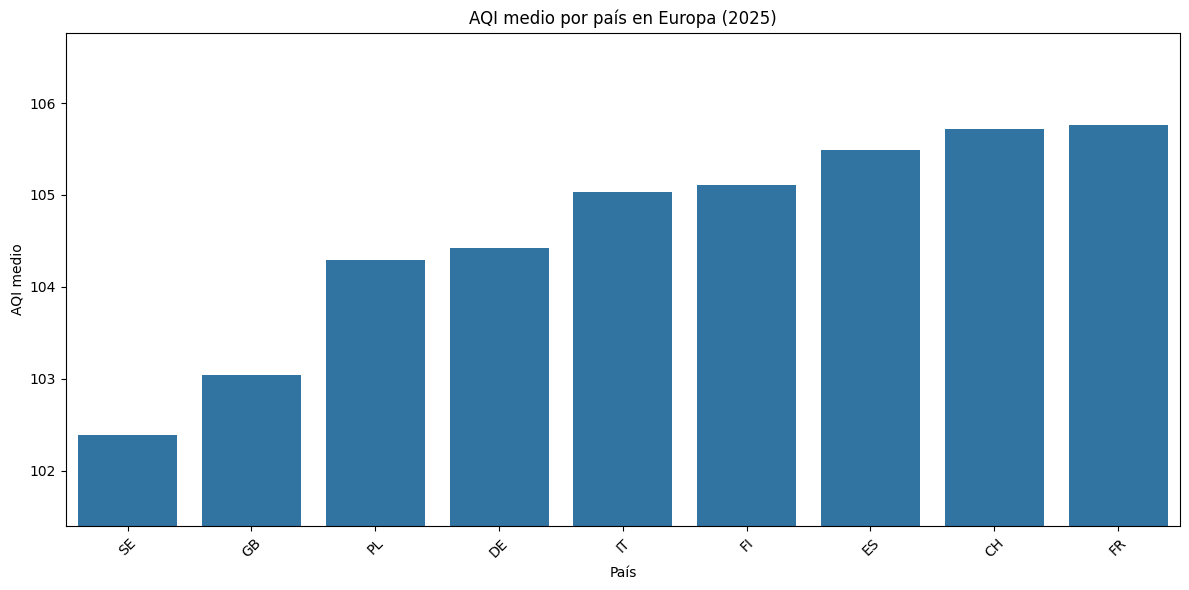

In [130]:


plt.figure(figsize=(12, 6))

sns.barplot(
    data=aqi_por_pais,
    x='country',
    y='aqi_medio'
)

plt.title(f"AQI medio por país en Europa ({ultimo_anio})")
plt.xlabel("País")
plt.ylabel("AQI medio")
plt.xticks(rotation=45)

# 🔥 CLAVE: ajustar eje Y
plt.ylim(
    aqi_por_pais['aqi_medio'].min() - 1,
    aqi_por_pais['aqi_medio'].max() + 1
)

plt.tight_layout()
plt.show()



## Interpretacion:
## 🌱 Países con mejor calidad del aire

## Los países con menor AQI medio son:

## Suecia (SE) ≈ 102.4

## Reino Unido (GB) ≈ 103.0

## 👉 Presentan mejor calidad del aire relativa dentro del conjunto analizado.

## ⚠️ Países con peor calidad del aire

## Los países con mayor AQI medio son:

## Francia (FR) ≈ 105.8

## Suiza (CH) ≈ 105.7

## España (ES) ≈ 105.5

## 👉 Indican una peor calidad del aire media, aunque sin valores extremos.